In [1]:
import itertools
import uproot
import sys
import site
import glob
import re
import math
sys.path.insert(0, site.getusersitepackages())

import numpy             as np
import awkward           as ak
import matplotlib.pyplot as plt
import pandas            as pd

# Wider Cells
from IPython.display                 import display, HTML, Markdown
from tqdm.notebook                   import tqdm
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# Función para extraer el número después de "P"
def extract_p_number(filename):
    match = re.search(r"P(\d+)", filename)
    if match:
        return int(match.group(1))
    return -1  # Devuelve un valor pequeño si no se encuentra "P"

In [3]:
run = 1444
run_files = glob.glob(f"/eos/experiment/wcte/data/2025_commissioning/offline_data/{run}/WCTE_offline_R{run}S*P*.root")
#/eos/experiment/wcte/data/2025_commissioning/"+str(run)+"/*.root

# Ordenar los archivos usando extract_p_number
run_files = sorted(run_files, key=extract_p_number)
part_files = [extract_p_number(file) for file in run_files]
len(run_files)

324

In [4]:
run_files

['/eos/experiment/wcte/data/2025_commissioning/offline_data/1444/WCTE_offline_R1444S0P0.root',
 '/eos/experiment/wcte/data/2025_commissioning/offline_data/1444/WCTE_offline_R1444S0P1.root',
 '/eos/experiment/wcte/data/2025_commissioning/offline_data/1444/WCTE_offline_R1444S0P2.root',
 '/eos/experiment/wcte/data/2025_commissioning/offline_data/1444/WCTE_offline_R1444S0P3.root',
 '/eos/experiment/wcte/data/2025_commissioning/offline_data/1444/WCTE_offline_R1444S0P4.root',
 '/eos/experiment/wcte/data/2025_commissioning/offline_data/1444/WCTE_offline_R1444S0P5.root',
 '/eos/experiment/wcte/data/2025_commissioning/offline_data/1444/WCTE_offline_R1444S0P6.root',
 '/eos/experiment/wcte/data/2025_commissioning/offline_data/1444/WCTE_offline_R1444S0P7.root',
 '/eos/experiment/wcte/data/2025_commissioning/offline_data/1444/WCTE_offline_R1444S0P8.root',
 '/eos/experiment/wcte/data/2025_commissioning/offline_data/1444/WCTE_offline_R1444S0P9.root',
 '/eos/experiment/wcte/data/2025_commissioning/off

In [5]:
# def read_all_parts():
#     tree = uproot.open(files[0])
#     keys = tree.keys()
#     print(keys)

#     branch = tree[keys[0]]
#     primal_event_numbers = [branch['event_number'].array().to_numpy()]
#     primal_window_times  = [branch['window_time'].array().to_numpy()]

#     for f in tqdm(files[1:]):
#         tree2 = uproot.open(f)
#         keys2 = tree2.keys()
#         for key2 in keys2:
#             branch2 = tree2[key2]
#             events = branch2['event_number'].array().to_numpy()
#             if len(events) != 0:
#                 primal_event_numbers.append(branch2['event_number'].array().to_numpy()+primal_event_numbers[-1].max()+1)
#                 primal_window_times.append(branch2['window_time'].array().to_numpy()+primal_window_times[-1].max()+1)   

# Select The Part File You Want To Use

# Select Only Those Events With The Same Number Of Waveforms And Hits

# For Those Good Events, Select Only Hits In Card 130 and Corresponding Channels And Etc

In [6]:
def selectec_good_events(part_file):
    tree = uproot.open(run_files[part_file]+":WCTEReadoutWindows")

    file_hit_card_ids      = tree["hit_mpmt_card_ids"].array()
    file_waveform_card_ids = tree["pmt_waveform_mpmt_card_ids"].array()

    num_hits = np.array([len(h) for h in file_hit_card_ids])
    num_wave = np.array([len(w) for w in file_waveform_card_ids])
    good_mask = (num_hits == num_wave) & (num_hits != 0)

    good_events = np.where(good_mask)[0]

    return good_events

In [7]:
def get_files_from_part(part_file):
    tree = uproot.open(run_files[part_file]+":WCTEReadoutWindows")
    file_hit_card_ids    = tree["hit_mpmt_card_ids"].array()
    file_hit_channel_ids = tree["hit_pmt_channel_ids"].array()
    file_hit_charges     = tree["hit_pmt_charges"].array()
    file_hit_times       = tree["hit_pmt_times"].array()

    return file_hit_card_ids, file_hit_channel_ids, file_hit_charges, file_hit_times

In [8]:
def select_good_parts(parts):
    good_parts = []
    for part_file in parts:
        tree = uproot.open(run_files[part_file]+":WCTEReadoutWindows")
        if np.any(tree["event_number"].array()):
            good_parts.append(part_file)

    return good_parts

In [9]:
def select_charges_for_beam_monitor(good_events, files, card, channels):#, variable="charge"):
    
    file_hit_charges_masked_LChannel = []
    file_hit_charges_masked_RChannel = []

    for ievt in good_events:
        event_hit_card_ids    = files[0][ievt]
        event_hit_channel_ids = files[1][ievt]
        event_hit_charges     = files[2][ievt]
        event_hit_times       = files[3][ievt]

        # Create mask to card 130
        # Create mask to channels 7&8 which correspond to ACT3L-R
        # Combine masks
        # Apply masks to event_hit_charges to get the charge in those specific channels for that specific card
        mask_card = event_hit_card_ids == card
        mask_channel_L = (event_hit_channel_ids == channels[0])
        mask_channel_R = (event_hit_channel_ids == channels[1])
        combined_mask_L = mask_card & mask_channel_L
        combined_mask_R = mask_card & mask_channel_R

        # if variable == "charge":
        l = event_hit_charges[combined_mask_L]
        r = event_hit_charges[combined_mask_R]
        if len(l) == len(r):
            file_hit_charges_masked_LChannel.append(l)
            file_hit_charges_masked_RChannel.append(r)

        # elif variable == "time":
        #     l = event_hit_times[combined_mask_L]
        #     r = event_hit_times[combined_mask_R]
        #     if len(l) == len(r):
        #         file_hit_charges_masked_LChannel.append(event_hit_times[combined_mask_L])
        #         file_hit_charges_masked_RChannel.append(event_hit_times[combined_mask_R])

    file_hit_charges_masked_LChannel = ak.flatten(file_hit_charges_masked_LChannel)
    file_hit_charges_masked_RChannel = ak.flatten(file_hit_charges_masked_RChannel)

    return file_hit_charges_masked_LChannel, file_hit_charges_masked_RChannel

In [10]:
good_parts = select_good_parts(part_files)

In [ ]:
# ACT0
ACT0L_charges = []
ACT0R_charges = []
# ACT1
ACT1L_charges = []
ACT1R_charges = []
# ACT2
ACT2L_charges = []
ACT2R_charges = []
for part in tqdm(good_parts, total=len(good_parts)):
    good_events = selectec_good_events(part)

    files = get_files_from_part(part)

    # ACT0 and ACT1 and ACT2
    # ACT0
    file_hit_charges_ACT0L, file_hit_charges_ACT0R = select_charges_for_beam_monitor(good_events, files, 130, [0,1])
    ACT0L_charges.append(file_hit_charges_ACT0L)
    ACT0R_charges.append(file_hit_charges_ACT0R)
    # ACT1
    file_hit_charges_ACT1L, file_hit_charges_ACT1R = select_charges_for_beam_monitor(good_events, files, 130, [2,3])
    ACT1L_charges.append(file_hit_charges_ACT1L)
    ACT1R_charges.append(file_hit_charges_ACT1R)
    # ACT2
    file_hit_charges_ACT2L, file_hit_charges_ACT2R = select_charges_for_beam_monitor(good_events, files, 130, [5,6])
    ACT2L_charges.append(file_hit_charges_ACT2L)
    ACT2R_charges.append(file_hit_charges_ACT2R)

  0%|          | 0/265 [00:00<?, ?it/s]

In [ ]:
# ACT0
ACT0L_charges = ak.flatten(ACT0L_charges)
ACT0R_charges = ak.flatten(ACT0R_charges)
ACT0L_charges = np.asarray(ACT0L_charges)
ACT0R_charges = np.asarray(ACT0R_charges)
print(len(ACT0L_charges))
print(len(ACT0R_charges))
# ACT1
ACT1L_charges = ak.flatten(ACT1L_charges)
ACT1R_charges = ak.flatten(ACT1R_charges)
ACT1L_charges = np.asarray(ACT1L_charges)
ACT1R_charges = np.asarray(ACT1R_charges)
print(len(ACT1L_charges))
print(len(ACT1R_charges))
# ACT2
ACT2L_charges = ak.flatten(ACT2L_charges)
ACT2R_charges = ak.flatten(ACT2R_charges)
ACT2L_charges = np.asarray(ACT2L_charges)
ACT2R_charges = np.asarray(ACT2R_charges)
print(len(ACT2L_charges))
print(len(ACT2R_charges))

41700
41700
45805
45805
47624
47624


In [130]:
ACTL = [i+j+k for (i,j,k) in zip(ACT0L_charges, ACT1L_charges, ACT2L_charges)]
ACTR = [i+j+k for (i,j,k) in zip(ACT0R_charges, ACT1R_charges, ACT2R_charges)]

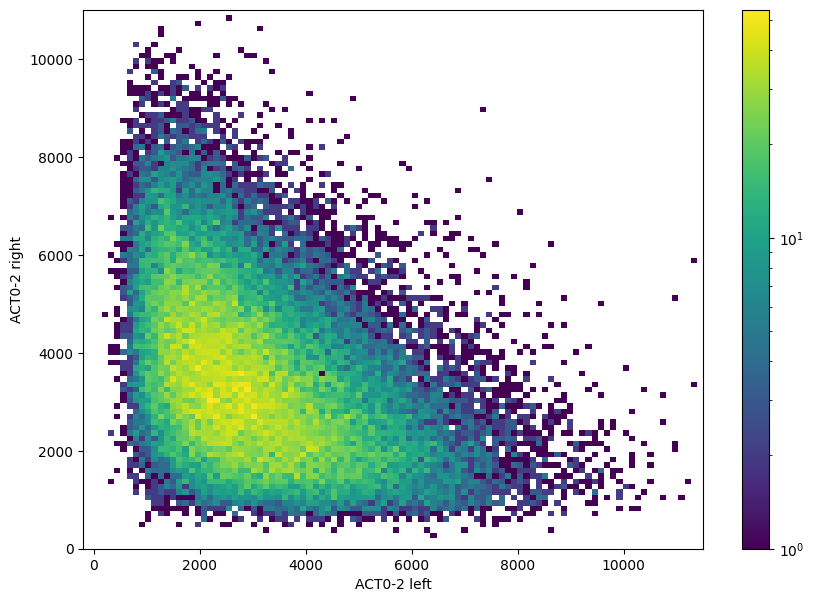

In [140]:
fig = plt.figure(figsize=(10,7))
h = plt.hist2d(ACTL, ACTR, bins=(100, 100), norm="log", range=((-200, 11500), (0, 11000)));
plt.colorbar(h[3]);
plt.ylabel("ACT0-2 right");
plt.xlabel("ACT0-2 left");

In [ ]:
ACT3L_charge = []
ACT3R_charge = []

good_parts = select_good_parts(part_files)

for part in tqdm(good_parts, total=len(good_parts)):
    good_events = selectec_good_events(part)
    files       = get_files_from_part(part)
    
    events     = good_events
    card_id    = files[0]
    channel_id = files[1]
    charge     = files[2]
    time       = files[3]

    # data = [(ievt, icard, ichan, ichar, itime) for ievt, icard, ichan, ichar, itime in zip(events, card_id, channel_id, charge, time)]

    # df = pd.DataFrame(data, columns=['event_id', "A", "B", "C", "D"])

    # df = df.explode(list('ABCD'))

    # df = df.rename(columns={"A": "card_id", "B": "channel_id", "C": "charge", "D": "time"})

    flat_event_ids   = []
    flat_card_ids    = []
    flat_channel_ids = []
    flat_charges     = []
    flat_times       = []

    for ievt in good_events:
        hits_in_evt = len(card_id[ievt])
        flat_event_ids.extend([ievt] * hits_in_evt)
        flat_card_ids.extend(card_id[ievt])
        flat_channel_ids.extend(channel_id[ievt])
        flat_charges.extend(charge[ievt])
        flat_times.extend(time[ievt])

    df = pd.DataFrame({
    "event_id":   flat_event_ids,
    "card_id":    flat_card_ids,
    "channel_id": flat_channel_ids,
    "charge":     flat_charges,
    "time":       flat_times
    })

    # Paso 1: Filtra por card 130 y canales 7 y 8
    filtered = df[(df["card_id"] == 130) & (df["channel_id"].isin([5, 6]))]

    # Paso 2: Cuenta cuántos hits hay por evento y canal
    counts = (
        filtered.groupby(["event_id", "channel_id"])
        .size()
        .unstack(fill_value=0)  # Esto crea columnas 7 y 8
    )

    # Paso 3: Quédate solo con eventos donde los hits en 7 y 8 son iguales
    valid_events = counts[counts.get(5, 0) == counts.get(6, 0)].index

    # Paso 4: Filtra el dataframe original
    result = filtered[filtered["event_id"].isin(valid_events)]

    charges_by_channel = result.groupby("channel_id")["charge"].apply(list)

    ACT3L_charge.append(charges_by_channel.get(5, []))
    ACT3R_charge.append(charges_by_channel.get(6, []))


  0%|          | 0/265 [00:00<?, ?it/s]

In [ ]:
ACT3L_charge = ak.flatten(ACT3L_charge)
ACT3R_charge = ak.flatten(ACT3R_charge)
ACT3L_charge = np.asarray(ACT3L_charge)
ACT3R_charge = np.asarray(ACT3R_charge)
print(len(ACT3L_charge))
print(len(ACT3R_charge))

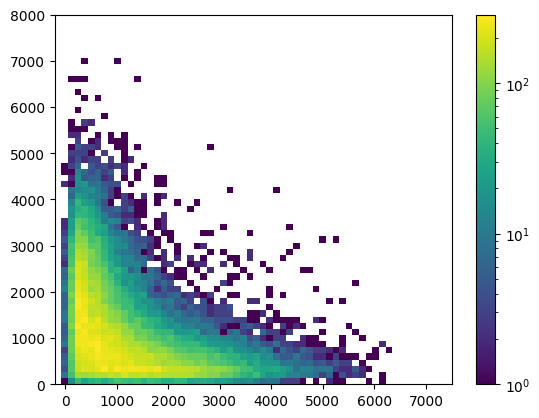

In [101]:
h = plt.hist2d(ACT3L_charge, ACT3R_charge, bins=(60, 60), norm="log", range=((-200, 7500), (0, 8000)));
plt.colorbar(h[3]);

In [84]:
def select_charges_for_beam_monitor(good_events, files, card, channel):
    # Convertir todo a numpy arrays planos (asumiendo que los datos caben en memoria)
    cards     = ak.to_numpy(ak.flatten(files[0][good_events]))
    channels  = ak.to_numpy(ak.flatten(files[1][good_events]))
    charges   = ak.to_numpy(ak.flatten(files[2][good_events]))
    event_ids = np.repeat(good_events, ak.num(files[0][good_events]).to_numpy())

    # Máscaras
    mask = (cards == card) & ((channels == channel[0]) | (channels == channel[1]))
    event_ids = event_ids[mask]
    channels  = channels[mask]
    charges   = charges[mask]

    # Contar hits por evento y canal
    unique_events, event_indices = np.unique(event_ids, return_inverse=True)
    left_counts  = np.bincount(event_indices, weights=(channels == channel[0]))
    right_counts = np.bincount(event_indices, weights=(channels == channel[1]))

    # Filtrar eventos válidos
    valid_events = unique_events[left_counts == right_counts]
    valid_mask   = np.isin(event_ids, valid_events)

    # Separar cargas
    left_charges  = charges[valid_mask & (channels == channel[0])]
    right_charges = charges[valid_mask & (channels == channel[1])]

    return left_charges, right_charges

In [86]:
# ACT0
ACT0L_charges = []
ACT0R_charges = []
# ACT1
ACT1L_charges = []
ACT1R_charges = []
# ACT2
ACT2L_charges = []
ACT2R_charges = []
# ACT3
ACT3L_charges = []
ACT3R_charges = []
# ACT4
ACT4L_charges = []
ACT4R_charges = []

for part in tqdm(good_parts, total=len(good_parts)):
    good_events = selectec_good_events(part)

    files = get_files_from_part(part)

    # ACT0 and ACT1 and ACT2
    # ACT0
    file_hit_charges_ACT0L, file_hit_charges_ACT0R = select_charges_for_beam_monitor(good_events, files, 130, [0,1])
    ACT0L_charges.append(file_hit_charges_ACT0L)
    ACT0R_charges.append(file_hit_charges_ACT0R)
    # ACT1
    file_hit_charges_ACT1L, file_hit_charges_ACT1R = select_charges_for_beam_monitor(good_events, files, 130, [2,3])
    ACT1L_charges.append(file_hit_charges_ACT1L)
    ACT1R_charges.append(file_hit_charges_ACT1R)
    # ACT2
    file_hit_charges_ACT2L, file_hit_charges_ACT2R = select_charges_for_beam_monitor(good_events, files, 130, [5,6])
    ACT2L_charges.append(file_hit_charges_ACT2L)
    ACT2R_charges.append(file_hit_charges_ACT2R)
    # ACT3
    file_hit_charges_ACT3L, file_hit_charges_ACT3R = select_charges_for_beam_monitor(good_events, files, 130, [7,8])
    ACT3L_charges.append(file_hit_charges_ACT3L)
    ACT3R_charges.append(file_hit_charges_ACT3R)
    # ACT4
    file_hit_charges_ACT4L, file_hit_charges_ACT4R = select_charges_for_beam_monitor(good_events, files, 130, [9,10])
    ACT4L_charges.append(file_hit_charges_ACT4L)
    ACT4R_charges.append(file_hit_charges_ACT4R)
 

  0%|          | 0/265 [00:00<?, ?it/s]

In [ ]:
# ACT0
ACT0L_charges = ak.flatten(ACT0L_charges)
ACT0R_charges = ak.flatten(ACT0R_charges)
ACT0L_charges = np.asarray(ACT0L_charges)
ACT0R_charges = np.asarray(ACT0R_charges)
print(len(ACT0L_charges))
print(len(ACT0R_charges))
# ACT1
ACT1L_charges = ak.flatten(ACT1L_charges)
ACT1R_charges = ak.flatten(ACT1R_charges)
ACT1L_charges = np.asarray(ACT1L_charges)
ACT1R_charges = np.asarray(ACT1R_charges)
print(len(ACT1L_charges))
print(len(ACT1R_charges))
# ACT2
ACT2L_charges = ak.flatten(ACT2L_charges)
ACT2R_charges = ak.flatten(ACT2R_charges)
ACT2L_charges = np.asarray(ACT2L_charges)
ACT2R_charges = np.asarray(ACT2R_charges)
print(len(ACT2L_charges))
print(len(ACT2R_charges))
# ACT3
ACT3L_charges = ak.flatten(ACT3L_charges)
ACT3R_charges = ak.flatten(ACT3R_charges)
ACT3L_charges = np.asarray(ACT3L_charges)
ACT3R_charges = np.asarray(ACT3R_charges)
print(len(ACT3L_charges))
print(len(ACT3R_charges))
# ACT4
ACT4L_charges = ak.flatten(ACT4L_charges)
ACT4R_charges = ak.flatten(ACT4R_charges)
ACT4L_charges = np.asarray(ACT4L_charges)
ACT4R_charges = np.asarray(ACT4R_charges)
print(len(ACT4L_charges))
print(len(ACT4R_charges))

38140
38140


In [92]:
ACTL_group1 = [i+j+k for (i,j,k) in zip(ACT0L_charges, ACT1L_charges, ACT2L_charges)]
ACTR_group1 = [i+j+k for (i,j,k) in zip(ACT0R_charges, ACT1R_charges, ACT2R_charges)]

ACTL_group2 = [i+j for (i,j) in zip(ACT3L_charges, ACT4L_charges)]
ACTR_group2 = [i+j for (i,j) in zip(ACT3R_charges, ACT4R_charges)]

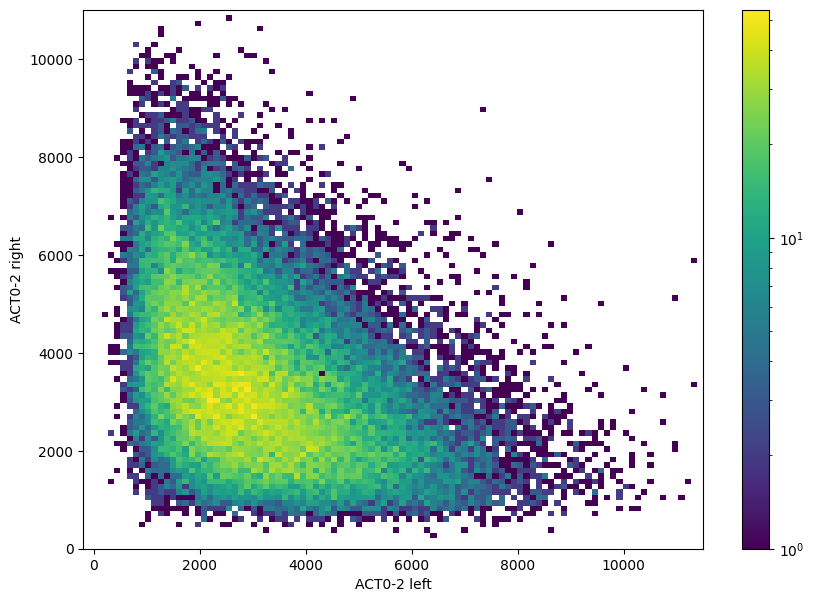

In [94]:
fig = plt.figure(figsize=(10,7))
h = plt.hist2d(ACTL_group1, ACTR_group1, bins=(100, 100), norm="log", range=((-200, 11500), (0, 11000)));
plt.colorbar(h[3]);
plt.ylabel("ACT0-2 right");
plt.xlabel("ACT0-2 left");

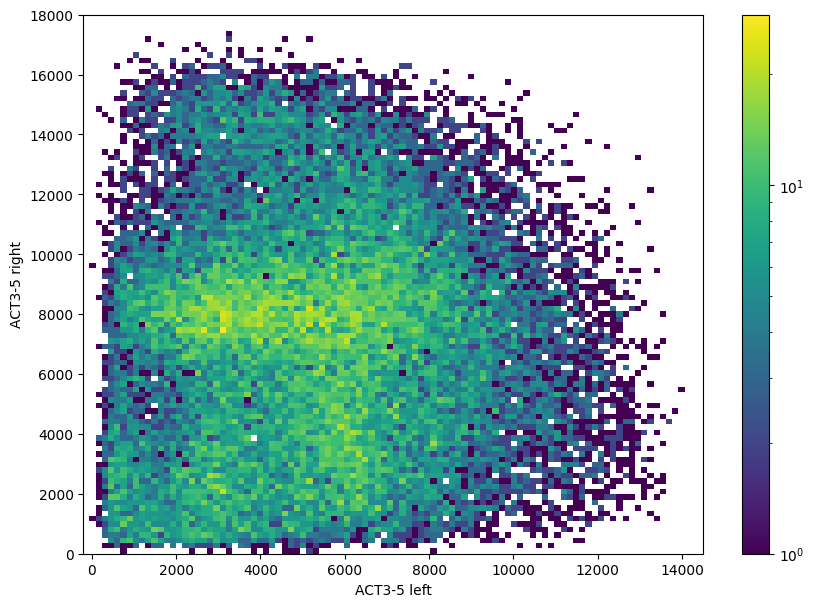

In [99]:
fig = plt.figure(figsize=(10,7))
h = plt.hist2d(ACTL_group2, ACTR_group2, bins=(100, 100), norm="log", range=((-200, 14500), (0, 18000)));
plt.colorbar(h[3]);
plt.ylabel("ACT3-5 right");
plt.xlabel("ACT3-5 left");

In [8]:
good_parts = select_good_parts(part_files)

In [ ]:
act0l_charges = []
act0r_charges = []

def act_charge(part):
    card = 130
    left_channel = 7
    right_channel = 8

    files = get_files_from_part(part)

    file_hit_card_ids    = files[0]
    file_hit_channel_ids = files[1]
    file_hit_charges     = files[2]

    for event in range(len(file_hit_card_ids)):
        # print(f"event {event}")
        event_hit_card_ids     = file_hit_card_ids[event]
        event_hit_channel_ids  = file_hit_channel_ids[event]
        event_hit_charges      = file_hit_charges[event]

        # Máscara para hits de la tarjeta deseada
        card_mask = (event_hit_card_ids == card)

        # Máscaras combinadas para canal izquierdo y derecho
        left_mask  = card_mask & (event_hit_channel_ids == left_channel)
        right_mask = card_mask & (event_hit_channel_ids == right_channel)

        act0l_charges.append(np.sum(event_hit_charges[left_mask]))
        act0r_charges.append(np.sum(event_hit_charges[right_mask]))

        # act0l_charges.append(np.sum(event_hit_charges[left_mask]))
        # act0r_charges.append(np.sum(event_hit_charges[right_mask]))


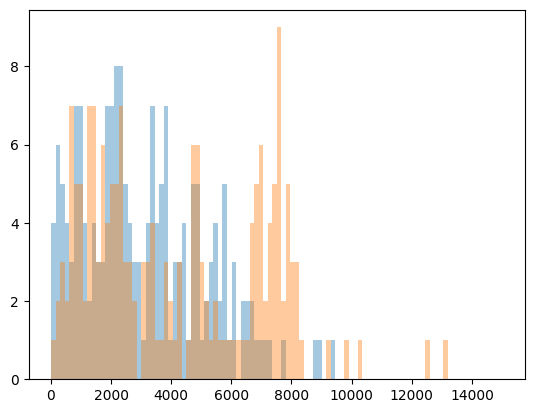

In [34]:
plt.hist(act0l_charges, bins=100, alpha=0.4, range=(10, 15000));
plt.hist(act0r_charges, bins=100, alpha=0.4, range=(10, 15000));
# plt.yscale("log");

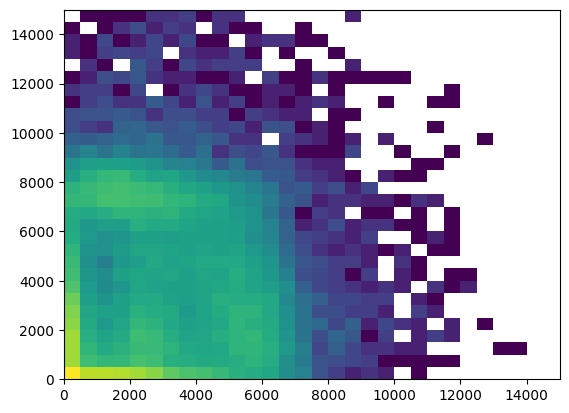

In [31]:
plt.hist2d(act0l_charges, act0r_charges, bins=(30,30), range=((0,15000), (0, 15000)), norm="log");

In [37]:
for part in tqdm(good_parts, total=len(good_parts)):
    card = 130
    left_channel = 7
    right_channel = 8

    files = get_files_from_part(part)

    file_hit_card_ids    = files[0]
    file_hit_channel_ids = files[1]
    file_hit_charges     = files[2]

    for event in range(len(file_hit_card_ids)):
        # print(f"event {event}")
        event_hit_card_ids     = file_hit_card_ids[event]
        event_hit_channel_ids  = file_hit_channel_ids[event]
        event_hit_charges      = file_hit_charges[event]

        # Máscara para hits de la tarjeta deseada
        card_mask = (event_hit_card_ids == card)

        # Máscaras combinadas para canal izquierdo y derecho
        left_mask  = card_mask & (event_hit_channel_ids == left_channel)
        right_mask = card_mask & (event_hit_channel_ids == right_channel)

        act0l_charges.append(np.sum(event_hit_charges[left_mask]))
        act0r_charges.append(np.sum(event_hit_charges[right_mask]))

        # act0l_charges.append(np.sum(event_hit_charges[left_mask]))
        # act0r_charges.append(np.sum(event_hit_charges[right_mask]))

  0%|          | 0/265 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
part = 0
files = get_files_from_part(part)

In [69]:
def create_df_from_file(files):
    cards    = files[0]
    channels = files[1]
    charges  = files[2]

    nevents = len(cards)
    print('nevents ', nevents)
    evts    = np.arange(nevents)
    nhits   = [len(cards[ievt]) for ievt in evts]
    evt_column = np.repeat(evts, nhits)

    xcards    = ak.flatten(cards)
    xchannels = ak.flatten(channels)
    xcharges  = ak.flatten(charges)
    df = pd.DataFrame({'evt':evt_column, 'card':xcards, 'channel':xchannels, 'charge':xcharges})
    return df



In [70]:
df_part0 = create_df_from_file(files)
df_part0.head()

nevents  850


,evt,card,channel,charge
0,0,17,2,118.0
1,0,23,4,131.0
2,0,23,8,191.0
3,0,23,9,204.0
4,0,23,15,236.0


In [60]:
dfs = [create_df_from_file(get_files_from_part(ipar)) for ipar in tqdm(good_parts[:10], total=len(good_parts[:10]))]

  0%|          | 0/10 [00:00<?, ?it/s]

nevents  530
nevents  850
nevents  794
nevents  830
nevents  835
nevents  782
nevents  797
nevents  1074
nevents  818
nevents  549


In [61]:
df_concat = pd.concat(dfs)

In [67]:
530+850

1380

In [66]:
df_concat["evt"].unique()

array([   0,    1,    2, ..., 1071, 1072, 1073])

In [32]:
_id_names = {(130, 0): "ACT0-L", (130, 1): "ACT0-R", (130, 2): "ACT1-L", (130, 3): "ACT1-R", (130, 4): "NC", (130, 5): "ACT2-L",
             (130, 6): "ACT2-R", (130, 7): "ACT3-L", (130, 8): "ACT3-R", (130, 9): "ACT4-L", (130, 10): "ACT4-R", (130, 11): "ACT5-L",
             (130, 12): "ACT5-R", (130, 13): "T1-0L", (130, 14): "T1-0R", (130, 15): "T1-1L", (130, 16): "T1-1R", (130, 17): "HC-0",
             (130, 18): "HC-1", (130, 19): "Trigger",
             (131, 0): "Trigger", (131, 1): "Lemo-1", (131, 2): "Lemo-2", (131, 3): "Lemo-3", (131, 4): "Lemo-4", (131, 5): "Lemo-5",
             (131, 6): "NC", (131, 7): "Lemo-6", (131, 8): "NC", (131, 9): "Laser", (131, 10): "T2", (131, 11): "T3",
             (131, 12): "T0-0L", (131, 13): "T0-1R", (131, 14): "T0-1L", (131, 15): "T0-1R", (131, 16): "NC", (131, 17): "PbG",
             (131, 18): "MuL", (131, 19): "MuR",
             (132, 0): "TOF-0", (132, 1): "TOF-1", (132, 2): "TOF-2", (132, 3): "TOF-3", (132, 4): "TOF-4", (132, 5): "TOF-5",
             (132, 6): "TOF-6", (132, 7): "TOF-7", (132, 8): "TOF-8", (132, 9): "NC", (132, 10): "TOF-9", (132, 11): "TOF-A",
             (132, 12): "TOF-B", (132, 13): "TOF-C", (132, 14): "TOF-D", (132, 15): "TOF-E", (132, 16): "TOF-F", (132, 17): "T4-L",
             (132, 18): "T4-R", (132, 19): "Trigger"}

In [37]:
def df_event_summary(df, ids):
    """ returns a DataFrame with one entry per event and the number of hits and total charge
    for the ids (each id is a pair (card ID, channel ID))
    inputs:
        df   : DataFrame with columns ‘event’, ‘card’, ‘channel’, ‘charge’ (to be extended to time)
        ids  : list of pairs (card, channel) i.e [(0, 0), (0, 1)]
    returns:
        DataFrame with columnes ‘event’ ‘name_of_card_channel_nhits’, ‘name_of_card_channel_charge’
    """
    nevts = np.max(df.evt) + 1
    xdf   = {"evt" : np.arange(nevts)}

    for  id in ids:
        card, channel = id
        sel   = (df.card == card) & (df.channel == channel)
        ievts = df[sel].evt.unique()

        _groups =  df[sel].groupby("evt")
        
        nhits         = _groups.count()["channel"]
        xhits         = np.zeros(nevts, int)
        xhits[ievts]  = nhits
        qtots         = _groups.sum()["charge"]
        xqtots        = np.zeros(nevts, float)
        xqtots[ievts] = qtots

        name = _id_names[(card, channel)]
        xdf[name+"_nhits"]  = xhits
        xdf[name+"_charge"] = xqtots
    
    return pd.DataFrame(xdf)

In [44]:

df_act0 = df_event_summary(df_part0, [(130, 0), (130, 1)])
df_act0.head()


,evt,ACT0-L_nhits,ACT0-L_charge,ACT0-R_nhits,ACT0-R_charge
0,0,1,712.0,1,235.0
1,1,1,624.0,0,0.0
2,2,1,1309.0,1,295.0
3,3,1,3253.0,0,0.0
4,4,0,0.0,1,561.0


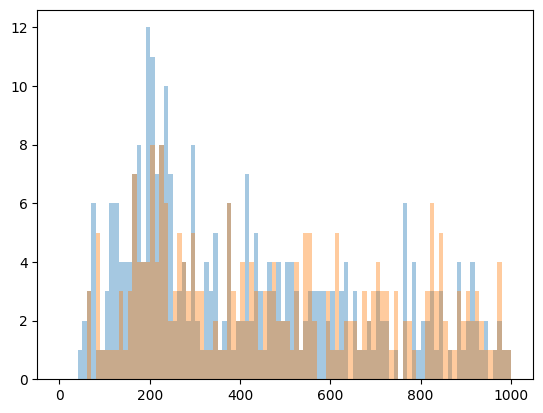

In [49]:
plt.hist(df_act0["ACT0-L_charge"], 100, alpha=0.4, range=(1, 1000));
plt.hist(df_act0["ACT0-R_charge"], 100, alpha=0.4, range=(1, 1000));
# plt.yscale("log");

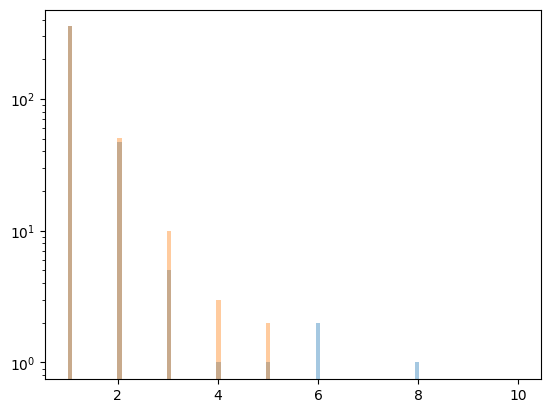

In [54]:
plt.hist(df_act0["ACT0-L_nhits"], 100, alpha=0.4, range=(1, 10));
plt.hist(df_act0["ACT0-R_nhits"], 100, alpha=0.4, range=(1, 10));
plt.yscale("log")

In [50]:
len(df_act0["ACT0-L_charge"]), len(df_act0["ACT0-R_charge"])

(530, 530)

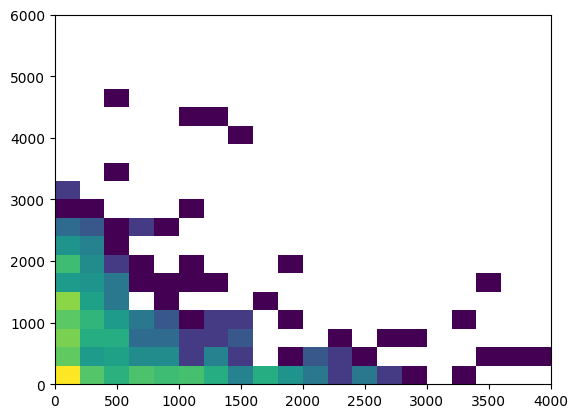

In [59]:
plt.hist2d(df_act0["ACT0-L_charge"], df_act0["ACT0-R_charge"], bins=(20,20), range=((0, 4000), (0, 6000)), norm="log");